## Load Packages and Data

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
import math
from prettytable import PrettyTable
from keras.models import Sequential,load_model
from keras.layers import LSTM, Dense, Activation, Dropout
from keras.regularizers import l1_l2
from keras import backend as K
from tensorflow.keras.optimizers import Adam,RMSprop
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import ModelCheckpoint

from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import torch
from torch import nn,optim
from torch.autograd import Variable
from torch.nn import init

# #antibody_by_week = pd.read_csv('antibody-by-week.csv')
# hosprate_by_week = pd.read_csv('weekly-hosp-rate-age.csv')
# deathrate_by_week= pd.read_csv('weekly-death-rate-age.csv')
# caserate_by_week = pd.read_csv('weekly-case-rate-age.csv')
variant_cases = pd.read_csv('variant-epi-data.csv')
dates = variant_cases['Sequence week'].map(lambda i:datetime.strptime(i.replace('/',''),"%m%d%Y"))
#delta, alpha, omicron
variant_cases = variant_cases[['Delta count','Delta percent','Alpha count','Alpha percent','Omicron count', 'Omicron percent']]
delta = variant_cases['Delta count']
alpha = variant_cases['Alpha count']
omicron = variant_cases['Omicron count']


In [6]:
## Load DAILY Data
all_cases = pd.read_csv('data-by-day.csv')[308:]
daily_cases = all_cases['CASE_COUNT']
def week_to_day(daily,percent):
    idx_week = 0
    variant_daily = []
    for i in range(len(daily)):
        if i % 7 == 0: idx_week+=1
        if idx_week-1 < len(percent):
            day_data = percent[idx_week-1]*daily[i]*0.01
            
            variant_daily.append(day_data)
    return variant_daily
    
alpha_percent = variant_cases['Alpha percent'].values
alpha_by_day = week_to_day(daily_cases.values,alpha_percent)
delta_percent = variant_cases['Delta percent'].values
delta_by_day = week_to_day(daily_cases.values,delta_percent)
omicron_percent = variant_cases['Omicron percent'].values
omicron_by_day = week_to_day(daily_cases.values,omicron_percent)
daily_dates = all_cases['date_of_interest'].map(lambda i:datetime.strptime(i.replace('/',''),"%m%d%Y"))

hosprate_by_day = pd.read_csv('hosp-by-day.csv')
deathrate_by_day= pd.read_csv('deaths-by-day.csv')
test_by_day = pd.read_csv('tests.csv')
all_varinat_by_day = pd.read_csv('data-by-day.csv')

day_data = {'hosp':list(hosprate_by_day[308:]['HOSPITALIZED_COUNT'][:-3]),
            'death':list(deathrate_by_day[308:]['DEATH_COUNT'][:-3]),
            'test':list(test_by_day[305:]['TOTAL_TESTS'][:-3]),
            'pos_rate':list(test_by_day[305:]['PERCENT_POSITIVE'][:-3]),
            'delta':delta_by_day,'alpha':alpha_by_day,'omicron':omicron_by_day,
            'all_variant':list(all_varinat_by_day[308:-3]['CASE_COUNT']),
            'BX':list(all_varinat_by_day[308:-3]['BX_CASE_COUNT']),
            'BK':list(all_varinat_by_day[308:-3]['BK_CASE_COUNT']),
            'MN':list(all_varinat_by_day[308:-3]['MN_CASE_COUNT']),
            'QN':list(all_varinat_by_day[308:-3]['QN_CASE_COUNT']),
            'SI':list(all_varinat_by_day[308:-3]['SI_CASE_COUNT'])}

day_df = pd.DataFrame(data=day_data,index=daily_dates[:-3])

findfont: Font family ['Time'] not found. Falling back to DejaVu Sans.


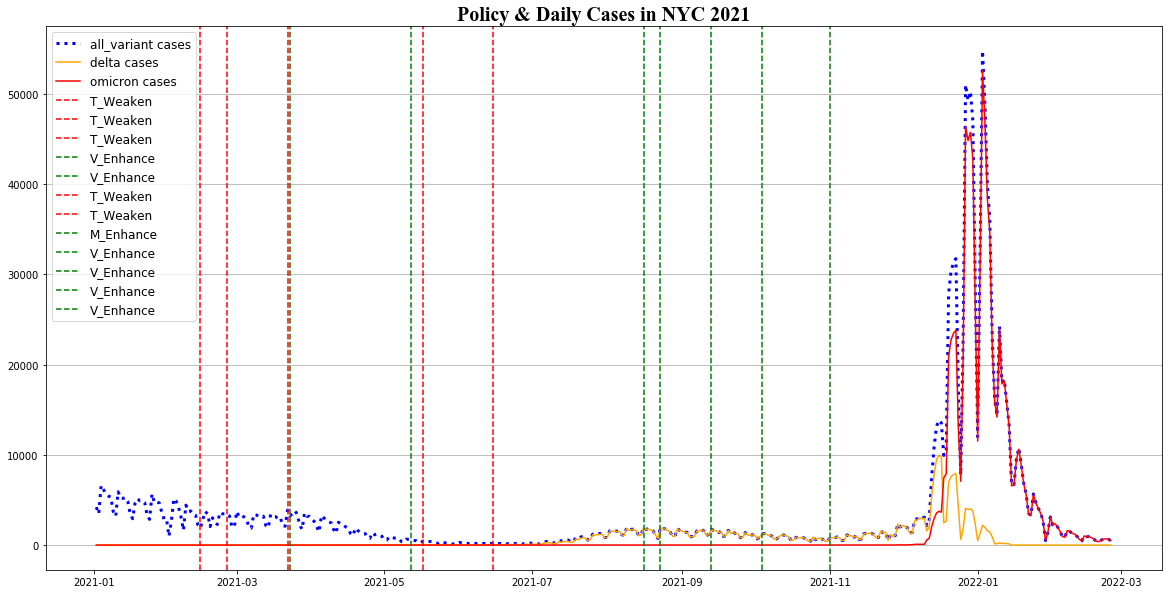

In [9]:
## plot the overall policy timings vs cases
plt.figure(figsize=(20,10))
plt.plot(day_df.index,day_df[['all_variant']],'b:',linewidth=3,label='all_variant cases')
plt.plot(day_df.index,day_df[['delta']],'orange',linewidth=1.5,label='delta cases')
plt.plot(day_df.index,day_df[['omicron']],'r',linewidth=1.5,label='omicron cases')

for i in range(1,len(policies)-2):
    if policies[i][2:] == 'Weaken': c = 'r'
    else: c = 'g'
    plt.axvline(x=day_df.index[policy_index[i]],color=c,label=policies[i],linestyle='--')
plt.title("Policy & Daily Cases in NYC 2021",fontdict={'family':'Times New Roman','size':20})
plt.legend(loc='upper left',prop={'family':'Time','size':12})
plt.grid(axis='y')

# TimePeriod Selection
# Delta 6.5 outbreak (index 154)
# Omicron 11.27 outbreak (index 329)

In [ ]:
## Feature Correlation
day_df_tmp1 = day_df[['hosp','death','test','pos_rate','delta','alpha','omicron','all_variant']]
sns.heatmap(day_df_tmp1.corr(),cmap='YlGnBu',annot=True)

In [14]:
## LSTM MODULE
class lstmModel():
    def __init__(self,win_len,params):
        self.input_shape = (1,win_len)
        self.lr,self.decay,self.batch_size,self.dropout,self.hidden_size,self.patience,self.epochs = params['lr'], params['decay'],params['batch_size'],params['dropout'],params['hidden_size'],params['patience'],params['epochs']
        self.optm=RMSprop(lr=self.lr,decay=self.decay)
        #self.optm=Adam(lr=1e-2,decay=1e-6)
        self.model = self.Get_model()
        
    def Reshape(self,X_data,y_data):
        return X_data.reshape(X_data.shape[0],1,X_data.shape[1]), y_data.reshape(y_data.shape[0],1)
        
    def get_Xy(self,y):
        win_len = self.input_shape[1]
        X_data,y_data=[],[]
        for i in range(len(y)-win_len):
            X_data.append(y[i:i+win_len])
            y_data.append(y[i+win_len])
        return np.array(X_data),np.array(y_data)
        
    def Get_model(self):
        model = Sequential()
        model.add(LSTM(self.hidden_size, input_shape=self.input_shape,  dropout=self.dropout, 
                    return_sequences=False,))
                    #kernel_regularizer=l1_l2(0.05,0.05), activity_regularizer=l1_l2(0.04,0.07)))
        model.add(Activation('relu'))
        #model.add(Activation('tanh'))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer= self.optm, metrics=['msle','mape'])
        print(model.summary())
        return model

    def train(self,train_X,train_y,val_X,val_y,plot_loss=False):
        train_X,train_y = self.Reshape(train_X,train_y)
        val_X,val_y = self.Reshape(val_X,val_y)
        print(train_X.shape,train_y.shape,val_X.shape,val_y.shape)

        early_stop = EarlyStopping(monitor='val_loss', patience=self.patience, mode='auto')

        history = self.model.fit(train_X, train_y, batch_size=self.batch_size, epochs=self.epochs, 
                                shuffle=False,
                                callbacks=[early_stop],
                                validation_data=(val_X, val_y))
                                #validation_split=0.2)
                                #validation_data=(x_test, y_test), reduce_lr
        if plot_loss:
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model train vs validation loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper right')
            plt.show()

    def predict(self,X):
        X = X.reshape(X.shape[0],1,X.shape[1])
        predict_X = self.model.predict(X)
        return predict_X


In [15]:
# Policy Timings (we used 1:12)
date_index=np.linspace(0,419,420)
policy_index = [9,  43, 54, 79, 80,
                130,135,164,226,233,
                254,275,303,358,359]
policies = ['V_Enhance','T_Weaken' ,'T_Weaken' ,'T_Weaken' ,'V_Enhance',
            'V_Enhance','T_Weaken' ,'T_Weaken' ,'M_Enhance','V_Enhance',
            'V_Enhance','V_Enhance','V_Enhance','M_Enhance', 'V_Enhance']
timings = ['1.11','2.14','2.25','3.22', '3.23', 
            '5.12','5.17','6.15','8.16','8.23', 
            '9.13' ,'10.4' ,'11.1','12.26','12.27' ]
colors = ['#9370DB','#A52A2A','#00FFFF','#8FBC8F','#FF1493',
          '#FF00FF','#FF69B4','#B22222','#000080','#FA8072',
          '#FF6347','#800080','#FFA500','k','m']

In [16]:
# Regression Model Building Part

def train_val_split(split_index,select_features):
    # print(select_features)
    normalizer = preprocessing.StandardScaler()
    X = normalizer.fit_transform(day_df[select_features])
    y = normalizer.fit_transform(day_df[['all_variant']]) # all data
    def train_val_test(X,y):
        # train test split
        X_,y_ = X[:split_index],y[:split_index]
        X_test,y_test = X[split_index:],y[split_index:]
        # validation set
        X_train,y_train = X_[:int(split_index*0.8)],y_[:int(split_index*0.8)]
        X_val,y_val = X_[int(split_index*0.8):],y_[int(split_index*0.8):]
        return X_train,y_train,X_val,y_val,X_test,y_test

    X_train,y_train,X_val,y_val,X_test,y_test = train_val_test(X,y)
    return X,y,X_train,y_train,X_val,y_val,X_test,y_test,normalizer

def day_to_week(data):
    week_data,i = [],0
    while i < len(data):
        if i+7 <= len(data):
            week_data.append(sum(data[i:i+7]))
        else:
            week_data.append(sum(data[i:]))
        i+=7
    return week_data

def day_to_weekavg(data):
    week_data,i = [],0
    while i < len(data):
        if i+7 <= len(data):
            week_data.append(sum(data[i:i+7])/7.0)
        else:
            week_data.append(sum(data[i:])/len(data[i:]))
        i+=7
    return week_data

def feature_selection(split_index):
    cor = day_df[['hosp','death','test','pos_rate','alpha','delta','omicron','all_variant']][:int(split_index*0.8)].corr()['all_variant']
    selected = []
    for i in range(len(cor)-1):
        if cor.values[i] > 0:
            selected.append(day_df.columns[i])
    return selected

def buildtrain_lstm(param,win_len,y_train,y_val,plot_loss=False):
    lstm = lstmModel(win_len=win_len,params=param)
    y_val = np.concatenate((y_train[-win_len:],y_val))
    Xtrain,ytrain = lstm.get_Xy(y_train)   # [0:160] -> X:[0:159] y:[1:160]
    Xval,yval = lstm.get_Xy(y_val)         # [160:200] -> X:[160:199] y:[161:200]
    #X_test,y_test = lstm.get_Xy(y_test)      # [200:300] -> X:[200:299] y:[201:300]
    lstm.train(train_X=Xtrain,train_y=ytrain,val_X=Xval,val_y=yval,plot_loss=plot_loss)
    pred_train,pred_val = lstm.predict(Xtrain),lstm.predict(Xval)
    lstm_score = r2_score(pred_val,yval)
    #lstm_score = mean_squared_error(pred_val,yval)
    return lstm,lstm_score,pred_train,pred_val

def buildtrain_xgb_rf(X_train,y_train,X_val,y_val,xgbr_param,rfr_param):
    xgbr = xgb.XGBRegressor(**xgbr_param)
    rfr = RandomForestRegressor(**rfr_param)
    xgbr.fit(X_train,y_train.ravel())
    rfr.fit(X_train,y_train.ravel())
    xgbr_val_pred = xgbr.predict(X_val)
    rfr_val_pred = rfr.predict(X_val)
    xgbr_score,rfr_score = r2_score(xgbr_val_pred,y_val),r2_score(rfr_val_pred,y_val)
    #xgbr_score,rfr_score = mean_squared_error(xgbr_val_pred,y_val),mean_squared_error(rfr_val_pred,y_val)
    
    return xgbr,xgbr_score,rfr,rfr_score

def model_select(xgbr,xgbr_score,rfr,rfr_score,lstm,lstm_score):
    print(xgbr_score,rfr_score,lstm_score)
    l = np.argmax(np.array([xgbr_score,rfr_score,lstm_score]))
    print('select model: ' + ['xgbr','rfr','lstm'][l])
    return [xgbr,rfr,lstm][l] 
    
def visualize(split_index,train_pred,val_pred,test_pred,y,ax,win_len=None,plot_policy=False):
    if not win_len:
        traindate,valdate,testdate = date_index[:int(split_index*0.8)],date_index[int(split_index*0.8):split_index],date_index[split_index:]
    else:
        traindate,valdate,testdate = date_index[win_len:int(split_index*0.8)],date_index[int(split_index*0.8):split_index],date_index[split_index:]
    ax.plot(date_index,y,'b:',label='real_cases',linewidth=3) # real case curve
    ax.plot(traindate,train_pred,color='g',label='train curve') # train case curve
    ax.plot(valdate,val_pred,color='m',label='val curve') # val case curve
    
    interval = PI(val_pred.reshape(-1),y[int(split_index*0.8):split_index].reshape(-1))
    
    ax.fill_between(valdate,val_pred.reshape(-1)+interval,val_pred.reshape(-1)-interval,alpha=0.3,color='skyblue')
    ax.plot(testdate,test_pred,color='r',label='test curve') # test case curve
    
    # plot policy 
    if plot_policy:
        if policies[policy_index.index(split_index)][2:] == 'Enhance': color = 'b'
        else: color = 'r'
        plt.axvline(x=split_index,color=color,linestyle='--')
    ax.legend(loc='best',fontsize='large')
    ax.grid()

def PI(pred,real): # 95% Prediction Inverval
    bias = sum((pred-real)**2)
    stder = math.sqrt(1/(len(real)-2)*bias)
    interval = 1.96*stder
    return interval

def metric_score(train_pred,y_train,val_pred,y_val,test_pred,y_test):

    print('Train MSE: ' + str(mean_squared_error(train_pred,y_train)))
    print('Train R2:  ' + str(r2_score(train_pred,y_train)))

    print('Validation MSE: ' + str(mean_squared_error(val_pred,y_val)))
    print('Validation R2:  ' + str(r2_score(val_pred,y_val)))

    print('Test MSE: ' + str(mean_squared_error(test_pred,y_test)))
    print('Test R2:  ' + str(r2_score(test_pred,y_test)))

def run(split_index,win_len,xgbr_param,rfr_param,lstm_param,ax,plot_policy=False):
    
    features = feature_selection(split_index)  # feature selection (correlation)
    features = ['hosp', 'death', 'test', 'pos_rate', 'alpha', 'omicron','all_variant','BX','MN','QN','SI','BK']

    X,y,X_train,y_train,X_val,y_val,X_test,y_test,normalizer = train_val_split(split_index,features)
    
    lstm,lstm_score,pred_train,pred_val = buildtrain_lstm(lstm_param,win_len,y_train,y_val,plot_loss=False)
    xgbr,xgbr_score,rfr,rfr_score = buildtrain_xgb_rf(X_train,y_train,X_val,y_val,xgbr_param,rfr_param)
    Model = model_select(xgbr,xgbr_score,rfr,rfr_score,lstm,lstm_score)
    
    
    if Model is lstm: 
        output = ['lstm',lstm_score]
        y_test = np.concatenate((y_val[-win_len:],y_test))
        X_test,y_test = lstm.get_Xy(y_test)
        train_prediction,val_prediction, test_prediction = pred_train,pred_val,Model.predict(X_test)
        metric_score(train_prediction,y_train[win_len:],val_prediction,y_val,test_prediction,y_test)
        visualize(split_index,train_prediction,val_prediction,test_prediction,y,ax,plot_policy=plot_policy,win_len=win_len)

    else:
        if Model is xgbr: output = ['xgbr',xgbr_score]
        else: output = ['rfr',rfr_score]

        train_prediction = Model.predict(X_train)
        val_prediction = Model.predict(X_val)
        test_prediction = Model.predict(X_test)
        metric_score(train_prediction,y_train,val_prediction,y_val,test_prediction,y_test)
        visualize(split_index,train_prediction,val_prediction,test_prediction,y,ax,plot_policy=plot_policy)

    # if lstm_score < 0.8 and xgbr_score < 0.8 and rfr_score < 0.8:
    #     print('policy' + str(split_index) + 'needs to be tuned')
    #     return split_index
        
    convertback = (test_prediction,y_test)
    pi_inter = PI((val_prediction).reshape(-1),(y_val).reshape(-1))

    return split_index,convertback, pi_inter,output
    

In [17]:
print('Policy timings that needs to tune the model: ' + str(tuning_set))
## For models requiring tuning, we follow lstm -> xgboost -> randomforest (stop when a best model is achieved)

Policy timings that needs to tune the model: []


## Part 1 Result

/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 70)                21840     
                                                                 
 activation_12 (Activation)  (None, 70)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 71        
                                                                 
Total params: 21,911
Trainable params: 21,911
Non-trainable params: 0
_________________________________________________________________
None
(27, 1, 7) (27, 1) (9, 1, 7) (9, 1)
Epoch 1/600
2/2 [==============================] - 3s 473ms/step - loss: 0.0263 - msle: 0.0152 - mape: 127.1523 - val_loss: 0.0156 - val_msle: 0.0011 - val_mape: 99.6386
Epoch 2/600
2/2 [==============================] - 0s 24ms/step - loss: 0.0241 - msle: 0.0126 - mape: 

/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 70)                21840     
                                                                 
 activation_13 (Activation)  (None, 70)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 71        
                                                                 
Total params: 21,911
Trainable params: 21,911
Non-trainable params: 0
_________________________________________________________________
None
(36, 1, 7) (36, 1) (11, 1, 7) (11, 1)
Epoch 1/600
2/2 [==============================] - 3s 502ms/step - loss: 0.0240 - msle: 0.0120 - mape: 113.4724 - val_loss: 0.0162 - val_msle: 3.5632e-05 - val_mape: 117.4577
Epoch 2/600
2/2 [==============================] - 0s 24ms/step - loss: 0.0229 - msle: 0.0110 -

/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 70)                21840     
                                                                 
 activation_14 (Activation)  (None, 70)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 71        
                                                                 
Total params: 21,911
Trainable params: 21,911
Non-trainable params: 0
_________________________________________________________________
None
(56, 1, 7) (56, 1) (16, 1, 7) (16, 1)
Epoch 1/600
3/3 [==============================] - 2s 245ms/step - loss: 0.0209 - msle: 0.0080 - mape: 109.3410 - val_loss: 0.0171 - val_msle: 0.0000e+00 - val_mape: 90.2368
Epoch 2/600
3/3 [==============================] - 0s 25ms/step - loss: 0.0196 - msle: 0.0078 - 

/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 70)                21840     
                                                                 
 activation_15 (Activation)  (None, 70)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 71        
                                                                 
Total params: 21,911
Trainable params: 21,911
Non-trainable params: 0
_________________________________________________________________
None
(57, 1, 7) (57, 1) (16, 1, 7) (16, 1)
Epoch 1/600
3/3 [==============================] - 2s 267ms/step - loss: 0.0212 - msle: 0.0079 - mape: 115.5422 - val_loss: 0.0140 - val_msle: 5.2902e-05 - val_mape: 91.4167
Epoch 2/600
3/3 [==============================] - 0s 20ms/step - loss: 0.0197 - msle: 0.0077 - 

/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 70)                21840     
                                                                 
 activation_16 (Activation)  (None, 70)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 71        
                                                                 
Total params: 21,911
Trainable params: 21,911
Non-trainable params: 0
_________________________________________________________________
None
(97, 1, 7) (97, 1) (26, 1, 7) (26, 1)
Epoch 1/600
5/5 [==============================] - 3s 154ms/step - loss: 0.0190 - msle: 0.0043 - mape: 97.4227 - val_loss: 0.0781 - val_msle: 0.0000e+00 - val_mape: 80.3158
Epoch 2/600
5/5 [==============================] - 0s 9ms/step - loss: 0.0161 - msle: 0.0042 - ma

/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 70)                21840     
                                                                 
 activation_17 (Activation)  (None, 70)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 71        
                                                                 
Total params: 21,911
Trainable params: 21,911
Non-trainable params: 0
_________________________________________________________________
None
(101, 1, 7) (101, 1) (27, 1, 7) (27, 1)
Epoch 1/600
5/5 [==============================] - 2s 123ms/step - loss: 0.0222 - msle: 0.0047 - mape: 111.2101 - val_loss: 0.0928 - val_msle: 0.0000e+00 - val_mape: 82.3253
Epoch 2/600
5/5 [==============================] - 0s 8ms/step - loss: 0.0189 - msle: 0.0047 -

/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 70)                21840     
                                                                 
 activation_18 (Activation)  (None, 70)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 71        
                                                                 
Total params: 21,911
Trainable params: 21,911
Non-trainable params: 0
_________________________________________________________________
None
(124, 1, 7) (124, 1) (33, 1, 7) (33, 1)
Epoch 1/600
6/6 [==============================] - 3s 93ms/step - loss: 0.0362 - msle: 0.0035 - mape: 99.0832 - val_loss: 0.1142 - val_msle: 0.0000e+00 - val_mape: 76.4836
Epoch 2/600
6/6 [==============================] - 0s 7ms/step - loss: 0.0277 - msle: 0.0037 - m

/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


None
(173, 1, 7) (173, 1) (46, 1, 7) (46, 1)
Epoch 1/600
8/8 [==============================] - 2s 63ms/step - loss: 0.0682 - msle: 0.0025 - mape: 95.9214 - val_loss: 0.0794 - val_msle: 0.0000e+00 - val_mape: 76.1176
Epoch 2/600
8/8 [==============================] - 0s 6ms/step - loss: 0.0513 - msle: 0.0027 - mape: 89.1195 - val_loss: 0.0578 - val_msle: 0.0000e+00 - val_mape: 64.3560
Epoch 3/600
8/8 [==============================] - 0s 6ms/step - loss: 0.0400 - msle: 0.0027 - mape: 89.9011 - val_loss: 0.0416 - val_msle: 0.0000e+00 - val_mape: 54.0108
Epoch 4/600
8/8 [==============================] - 0s 5ms/step - loss: 0.0315 - msle: 0.0027 - mape: 96.8221 - val_loss: 0.0287 - val_msle: 0.0000e+00 - val_mape: 44.0866
Epoch 5/600
8/8 [==============================] - 0s 6ms/step - loss: 0.0242 - msle: 0.0027 - mape: 103.1954 - val_loss: 0.0181 - val_msle: 0.0000e+00 - val_mape: 34.0601
Epoch 6/600
8/8 [==============================] - 0s 5ms/step - loss: 0.0182 - msle: 0.0026 - map

/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 70)                21840     
                                                                 
 activation_20 (Activation)  (None, 70)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 71        
                                                                 
Total params: 21,911
Trainable params: 21,911
Non-trainable params: 0
_________________________________________________________________
None
(179, 1, 7) (179, 1) (47, 1, 7) (47, 1)
Epoch 1/600
8/8 [==============================] - 2s 78ms/step - loss: 0.0645 - msle: 0.0026 - mape: 98.1548 - val_loss: 0.0563 - val_msle: 0.0000e+00 - val_mape: 68.0041
Epoch 2/600
8/8 [==============================] - 0s 6ms/step - loss: 0.0445 - msle: 0.0026 - m

/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


None
(196, 1, 7) (196, 1) (51, 1, 7) (51, 1)
Epoch 1/600
9/9 [==============================] - 3s 68ms/step - loss: 0.0702 - msle: 0.0020 - mape: 96.4592 - val_loss: 0.0463 - val_msle: 0.0000e+00 - val_mape: 70.9001
Epoch 2/600
9/9 [==============================] - 0s 5ms/step - loss: 0.0509 - msle: 0.0022 - mape: 84.7040 - val_loss: 0.0321 - val_msle: 0.0000e+00 - val_mape: 58.1453
Epoch 3/600
9/9 [==============================] - 0s 6ms/step - loss: 0.0382 - msle: 0.0022 - mape: 85.8880 - val_loss: 0.0208 - val_msle: 0.0000e+00 - val_mape: 45.6768
Epoch 4/600
9/9 [==============================] - 0s 8ms/step - loss: 0.0281 - msle: 0.0022 - mape: 92.1474 - val_loss: 0.0122 - val_msle: 0.0000e+00 - val_mape: 33.2688
Epoch 5/600
9/9 [==============================] - 0s 6ms/step - loss: 0.0199 - msle: 0.0022 - mape: 98.1559 - val_loss: 0.0064 - val_msle: 0.0000e+00 - val_mape: 21.5395
Epoch 6/600
9/9 [==============================] - 0s 5ms/step - loss: 0.0139 - msle: 0.0022 - mape

/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 70)                21840     
                                                                 
 activation_22 (Activation)  (None, 70)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 71        
                                                                 
Total params: 21,911
Trainable params: 21,911
Non-trainable params: 0
_________________________________________________________________
None
(213, 1, 7) (213, 1) (55, 1, 7) (55, 1)
Epoch 1/600
9/9 [==============================] - 2s 63ms/step - loss: 0.0713 - msle: 0.0022 - mape: 90.5899 - val_loss: 0.0482 - val_msle: 0.0000e+00 - val_mape: 72.1153
Epoch 2/600
9/9 [==============================] - 0s 6ms/step - loss: 0.0497 - msle: 0.0022 - m

/opt/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 70)                21840     
                                                                 
 activation_23 (Activation)  (None, 70)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 71        
                                                                 
Total params: 21,911
Trainable params: 21,911
Non-trainable params: 0
_________________________________________________________________
None
(235, 1, 7) (235, 1) (61, 1, 7) (61, 1)
Epoch 1/600
10/10 [==============================] - 3s 104ms/step - loss: 0.0482 - msle: 0.0020 - mape: 81.6168 - val_loss: 0.0357 - val_msle: 0.0000e+00 - val_mape: 54.4026
Epoch 2/600
10/10 [==============================] - 0s 5ms/step - loss: 0.0265 - msle: 0.002

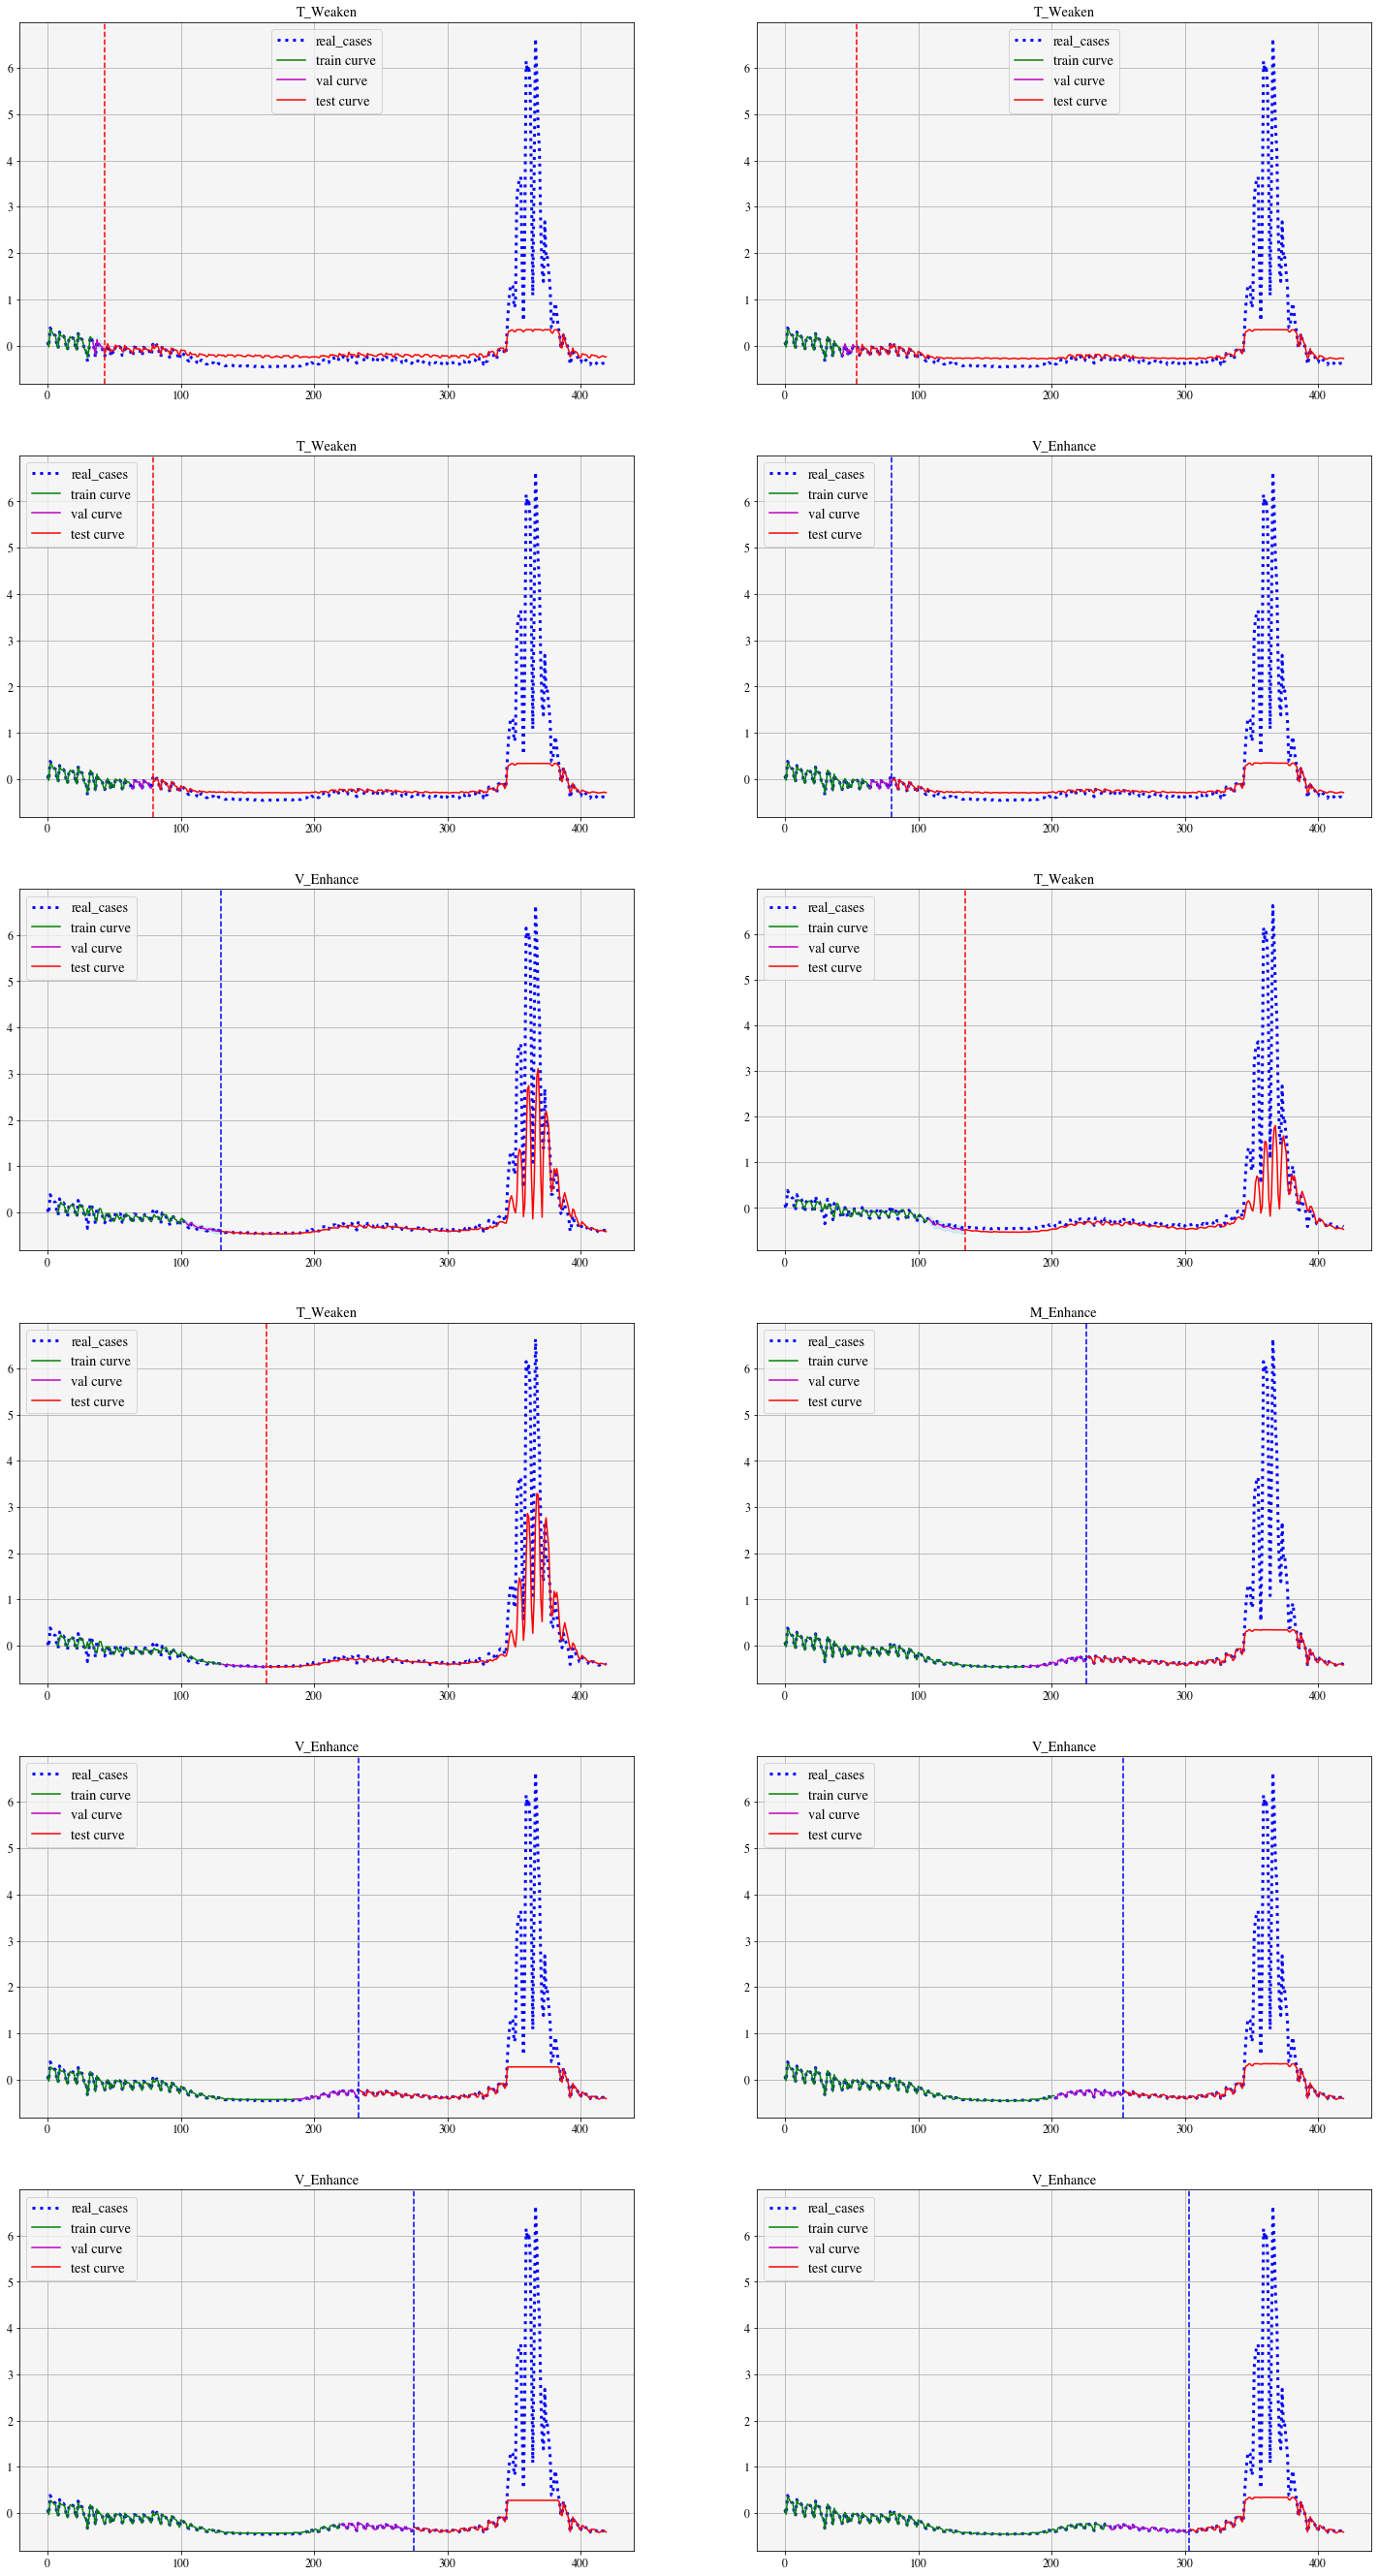

In [23]:
## USE Experienced Parameters at first & Tuning models with bad performance

xgbr_param = {'seed':0,'n_estimators':600,'min_child_weight':1,'max_depth':3,'gamma':0.02,'subsample':0.8,'learning_rate':0.08}
rfr_param = {'n_estimators': 150}
lstm_param = {'lr':1e-3,'decay':1e-6,'batch_size':24,'dropout':0.03,'hidden_size':70,'patience':20,'epochs':600}

outpt = PrettyTable(["Policy_category", "date", "Model Chose",'Val_Score'])
outpt.align["Policy_category"] = "1" 
outpt.padding_width = 1

tuning_set = []
finish_set = []
plt.figure(figsize=(25,48))
for i in range(1,13):
    ax = plt.subplot(6,2,i)
    ax.set_title(policies[i])
    idx = policy_index[i]
    result = run(idx,7,xgbr_param,rfr_param,lstm_param,ax,plot_policy=True)
    if type(result) is int: 
        tuning_set.append(result)
    else: 
        finish_set.append(result[:-1])
        outpt.add_row([policies[i],timings[i],result[-1][0],result[-1][1]])
print(outpt)

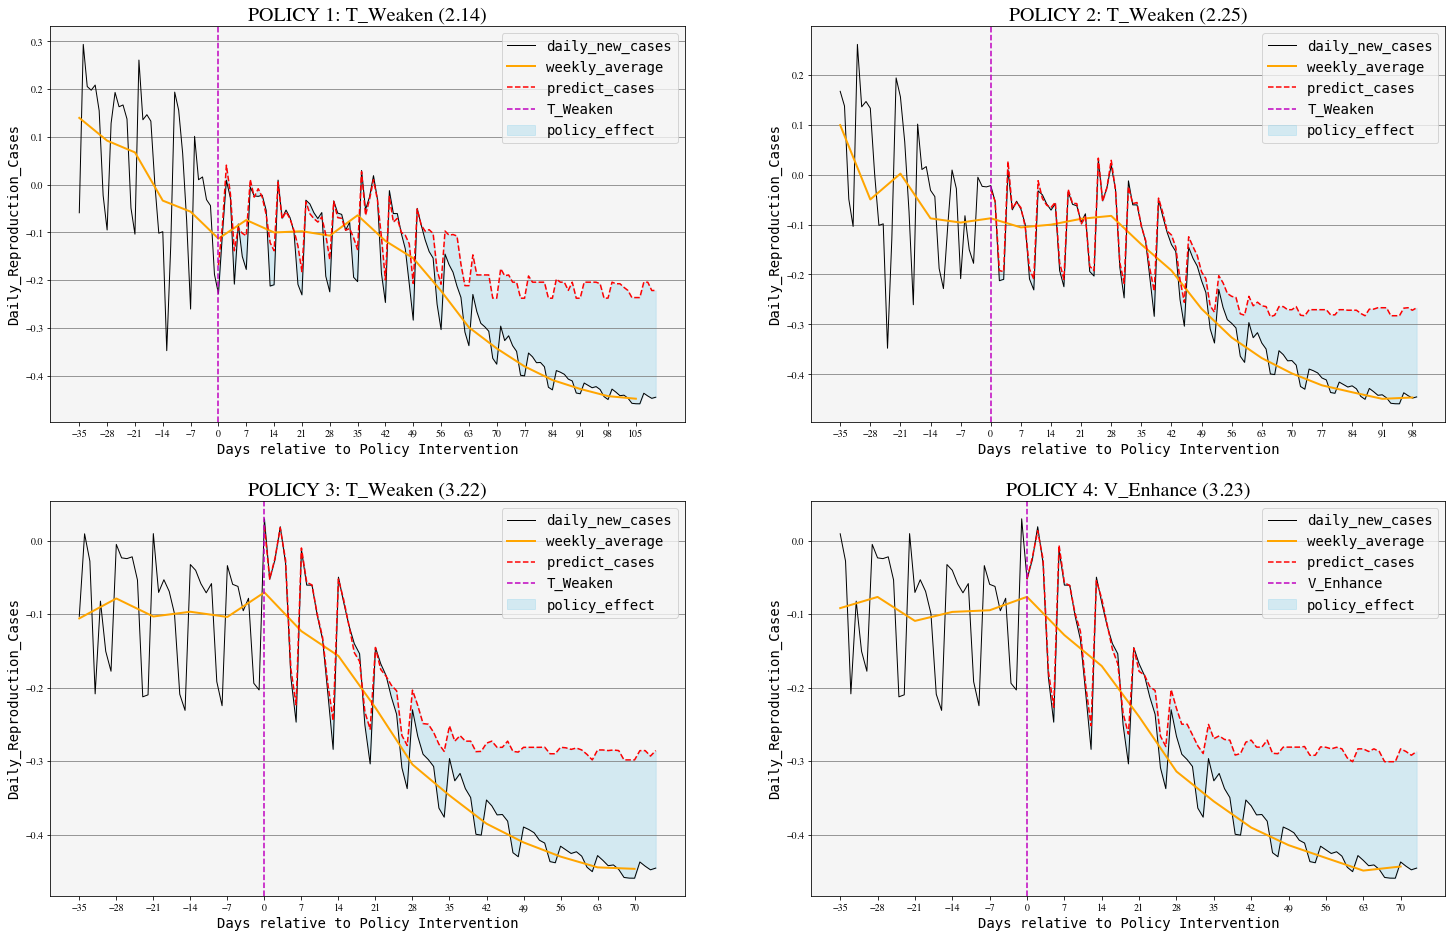

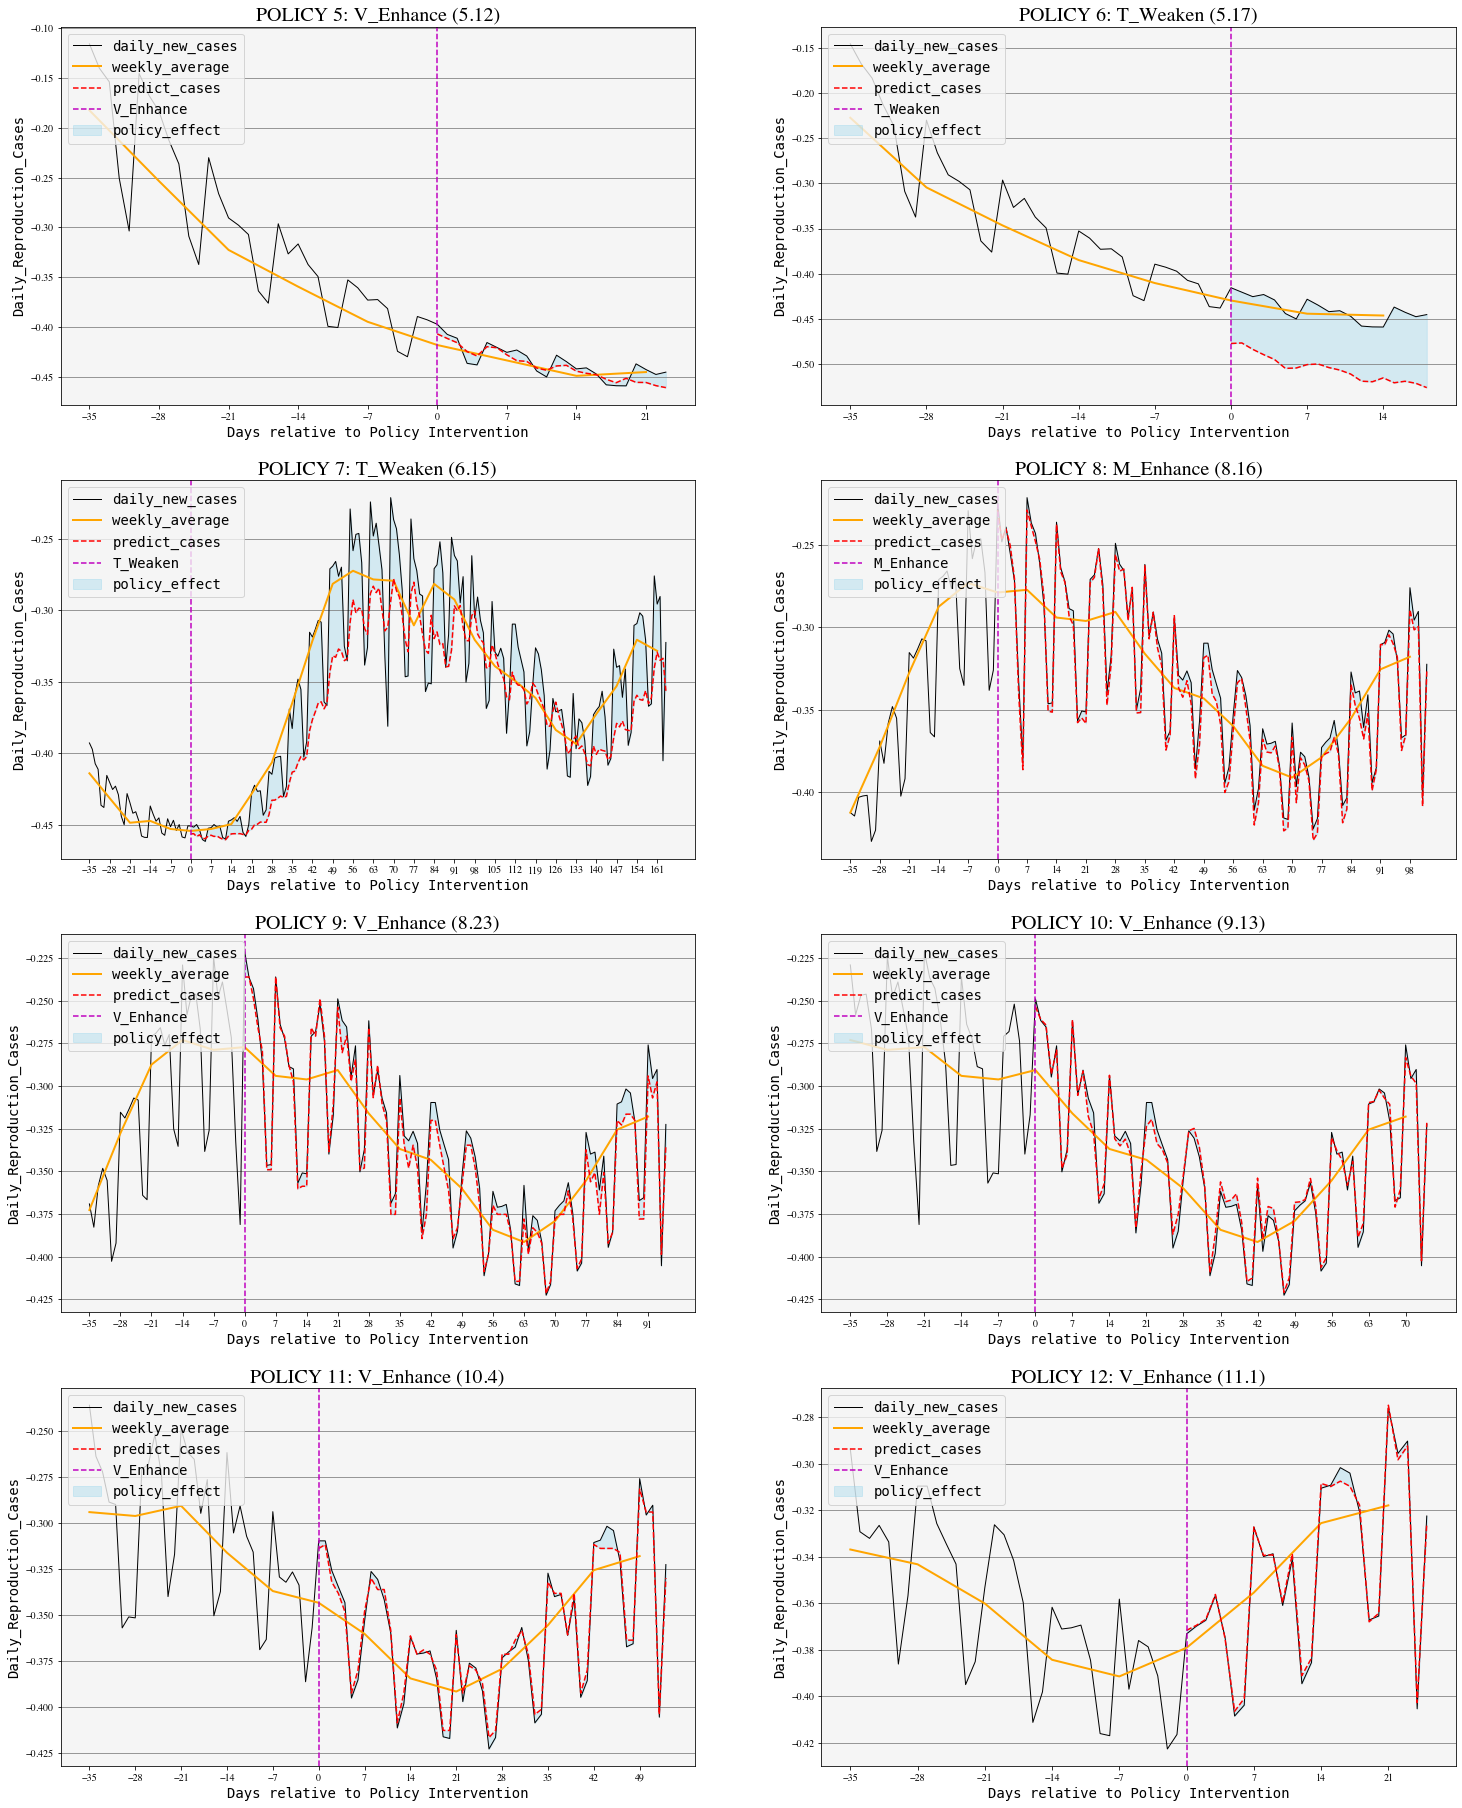

In [40]:
# Visualize Prediction & Real Data

dates_by_day = day_df.index
cases_by_day = day_df['all_variant'].values

#cases_by_day = np.array(cum_day_data)
# for i in policies
#day_df[['all_variant']].plot()
standardize = preprocessing.StandardScaler()
cases_by_day = standardize.fit_transform(cases_by_day.reshape(-1,1)).reshape(-1)

# plt.figure(figsize=(25,35))

policy_effects = []
policy_effects_PI = []

for i in range(1,len(policy_index)-2):
    index = policy_index[i]
    if index < 154:
        end_date = 154 #165# + 20
    elif 154 < index and index < 329:
        end_date = 329 # + 10
    # else:
    #     end_date = len(day_df)
    # if index + 180 > 329: end_date = 329
    # else: end_date = index + 180

    if index+92 < len(cases_by_day):
        x_range = range(-35,end_date-index,1)
        tick_range = range(-35,end_date-index,7)
        y = cases_by_day[index-35:index+(end_date-index)] 
    else:
        y = cases_by_day[index-35:]
        x_range = range(-35,len(y)-35,1)
        tick_range = range(-35,57,7)
        
    y_pred = finish_set[i-1][1][0][:(end_date-index)]
    y_pred = np.array(y_pred).reshape(-1)

    if i == 1:   plt.figure(figsize=(25,16))
    if i == 5:   plt.figure(figsize=(25,32))
    if i == 13:  plt.figure(figsize=(25,8))
    plt.rcParams['axes.facecolor']='whitesmoke'
    

    plt.rc('font',family='Times', size=10)

    font1 = {'family':'Times', 'size':20}
    font2 = {'family':'monospace', 'size':14}
    
    if i < 5:  ax,lo = plt.subplot(2,2,i),'upper right'
    elif i >= 5 and i < 13: 
        ax = plt.subplot(4,2,i-4)
        if i == 11 or i == 12: lo = 'upper left'
        else: lo = 'upper left'

    week_y = np.array(day_to_weekavg(y))

    effect = y[35:]-y_pred
    policy_effects.append(effect)
    policy_effects_PI.append(finish_set[i-1][2])
    
    ax.set_title('POLICY ' + str(i) + ': ' + policies[i] + ' ('+timings[i]+')',font1)
    ax.plot(x_range,y,'k',label='daily_new_cases',linewidth=1.0)
    ax.plot(tick_range,week_y,color='orange',linestyle='-',label='weekly_average',linewidth=2.0)
    ax.plot(x_range[35:],y_pred,'r--',label='predict_cases')
    
    ax.fill_between(x_range[35:],y[35:],y_pred,alpha=0.3,color='skyblue',label='policy_effect')

    ax.set_xticks(tick_range)
    ax.set_xlabel('Days relative to Policy Intervention',font2)
    ax.set_ylabel('Daily_Reproduction_Cases',font2)

    ax.axvline(x=0,color='m',linestyle='dashed',label=policies[i])
    ax.grid(axis='y',color='gray')
    ax.legend(loc=lo,prop=font2)


## Part 2 Result

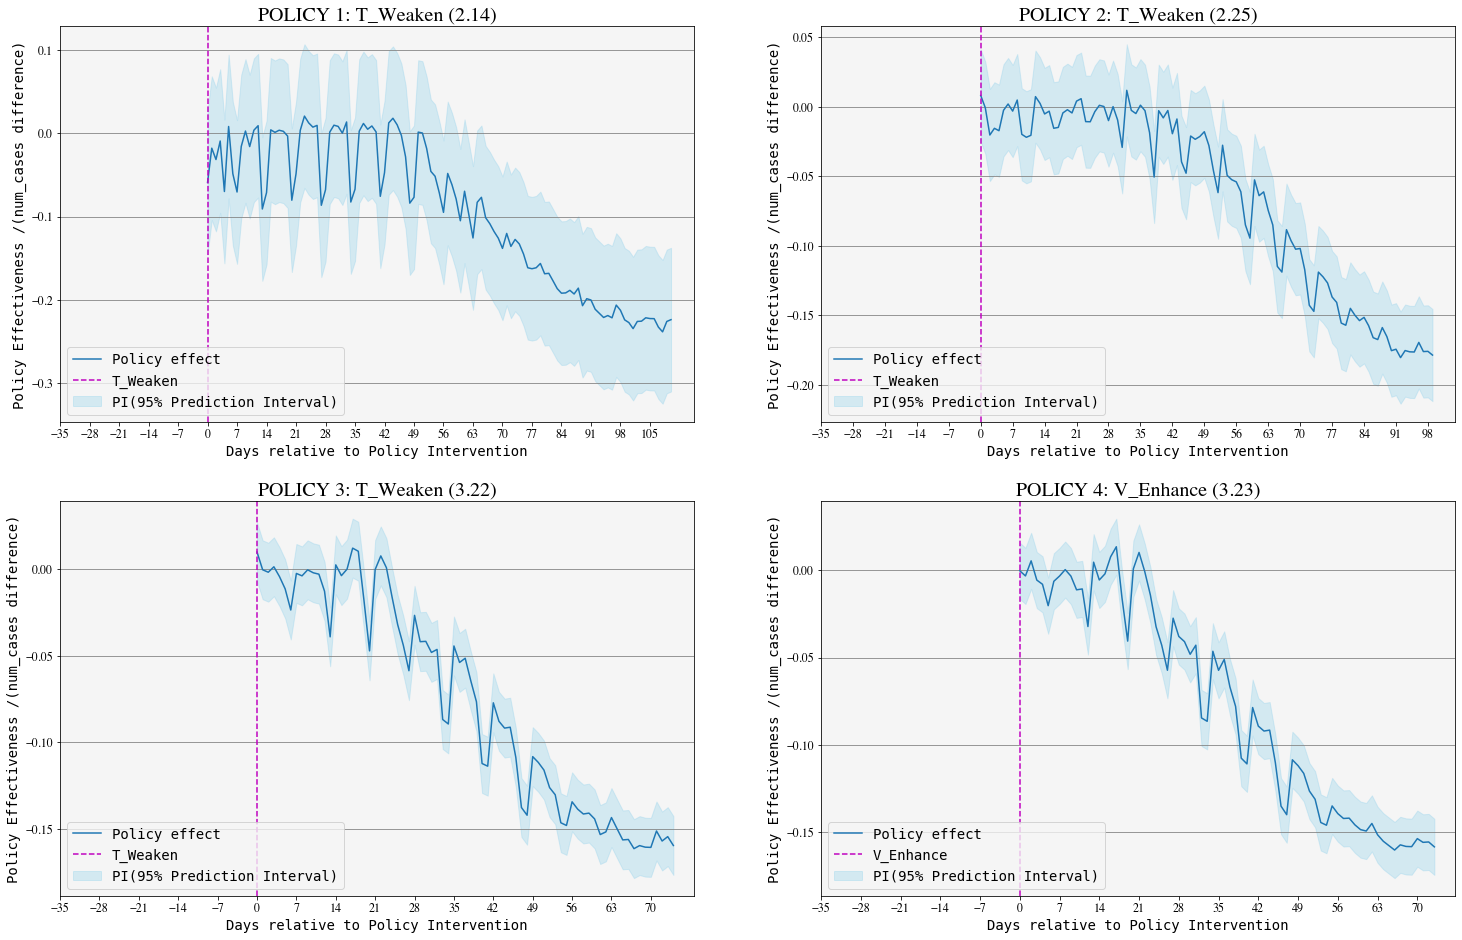

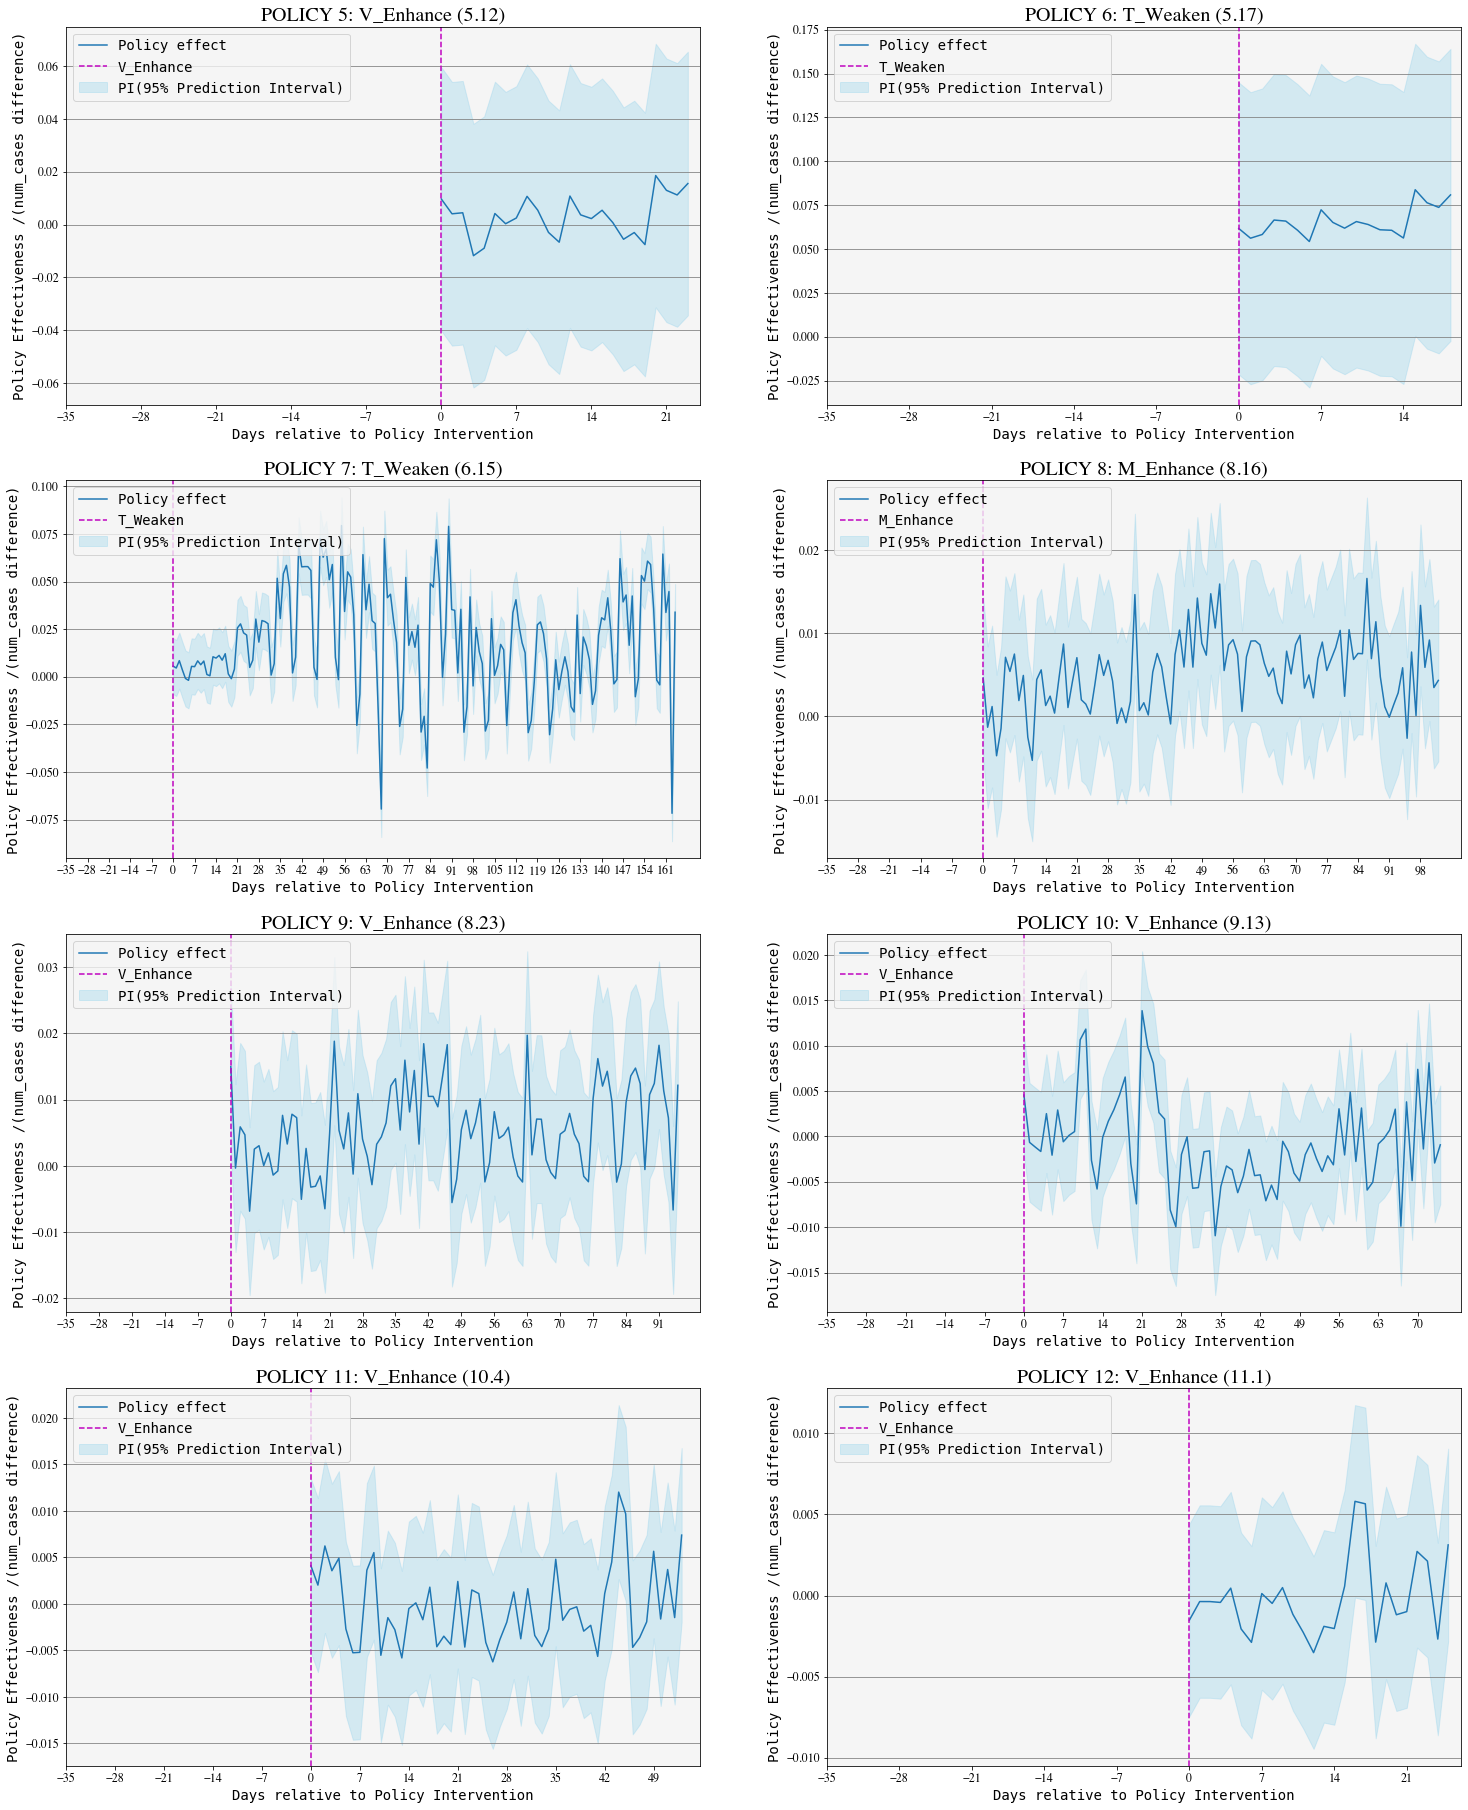

In [42]:
## Visualize the effect of policies (in terms of AE)
for i in range(1,len(policy_index)-2):
    effect = policy_effects[i-1]
    pi_interval = policy_effects_PI[i-1]

    index = policy_index[i]
    if index < 154:
        end_date = 154# + 20
    elif 154 < index and index < 329:
        end_date = 329# + 10
    else:
        end_date = len(day_df)

    # if index + 180 > 329: end_date = 329
    # else: end_date = index + 180

    if index+92 < len(cases_by_day):
        x_range = range(-35,end_date-index,1)
        tick_range = range(-35,end_date-index,7)
        y = cases_by_day[index-35:index+(end_date-index)] 
    else:
        y = cases_by_day[index-35:]
        x_range = range(-35,len(y)-35,1)
        tick_range = range(-35,57,7)
   
    if i == 1:   plt.figure(figsize=(25,16))
    if i == 5:   plt.figure(figsize=(25,32))
    if i == 13:  plt.figure(figsize=(25,8))
    plt.rcParams['axes.facecolor']='whitesmoke'
    plt.rc('font',family='Times', size=12)

    font1 = {'family':'Times', 'size':20}
    font2 = {'family':'monospace', 'size':14}
    if i < 5:  ax,lo = plt.subplot(2,2,i),'lower left'
    elif i >= 5 and i < 13: 
        ax = plt.subplot(4,2,i-4)
        if i == 11 or i == 12: lo = 'upper left'
        else: lo = 'upper left'
    ax.set_title('POLICY ' + str(i) + ': ' + policies[i] + ' ('+timings[i]+')',font1)
    ax.plot(x_range[35:],effect,label='Policy effect')

    ax.fill_between(x_range[35:],effect+pi_interval,effect-pi_interval,alpha=0.3,color='skyblue',label='PI(95% Prediction Interval)')
    ax.set_xticks(tick_range)
    ax.set_xlabel('Days relative to Policy Intervention',font2)
    ax.set_ylabel('Policy Effectiveness /(num_cases difference)',font2)
    ax.axvline(x=0,color='m',linestyle='dashed',label=policies[i])
    ax.grid(axis='y',color='gray')
    ax.legend(loc=lo,prop=font2)

In [43]:
## The policy effect Table
x = PrettyTable(["Policy_category","date","avg_effect","PI(95%)"])
x.align["category"] = "1" 
x.padding_width = 1 

for i in range(len(policy_effects)):
        avg_effect = sum(policy_effects[i])/len(policy_effects)
        category = 'policy' + str(i+1) + ' ' + policies[i+1]
        d = timings[i+1]
        it = '(' + str(round((avg_effect - policy_effects_PI[i]),3)) + ', ' + str(round((avg_effect + policy_effects_PI[i]),3)) + ')'
        x.add_row([category,d,round(avg_effect,4),it])
print(x)

+--------------------+------+------------+------------------+
|  Policy_category   | date | avg_effect |     PI(95%)      |
+--------------------+------+------------+------------------+
|  policy1 T_Weaken  | 2.14 |  -0.8725   | (-0.959, -0.786) |
|  policy2 T_Weaken  | 2.25 |   -0.545   | (-0.578, -0.512) |
|  policy3 T_Weaken  | 3.22 |  -0.4732   | (-0.49, -0.456)  |
| policy4 V_Enhance  | 3.23 |  -0.4709   | (-0.487, -0.455) |
| policy5 V_Enhance  | 5.12 |   0.0063   | (-0.044, 0.056)  |
|  policy6 T_Weaken  | 5.17 |   0.1038   |  (0.021, 0.187)  |
|  policy7 T_Weaken  | 6.15 |   0.2565   |  (0.242, 0.271)  |
| policy8 M_Enhance  | 8.16 |   0.0455   |  (0.036, 0.055)  |
| policy9 V_Enhance  | 8.23 |   0.0441   |  (0.031, 0.057)  |
| policy10 V_Enhance | 9.13 |  -0.0055   | (-0.012, 0.001)  |
| policy11 V_Enhance | 10.4 |  -0.0014   | (-0.011, 0.008)  |
| policy12 V_Enhance | 11.1 |  -0.0004   | (-0.006, 0.006)  |
+--------------------+------+------------+------------------+
